# Test times of operation given specific size of a dataset

## Steps:

1. Generate N sessions with K items. Store those in `JSON` file in temp directory.
2. Train (prepare) model. Measure training time.
3. Measure model size.
4. Recommend products the 1000 sample records. Measure the overall time and the mean response time.
5. Analyze results.

In [1]:
import datetime
import os
import tempfile

import datasize
import numpy as np
import pandas as pd

from pympler import asizeof

import matplotlib.pyplot as plt
import seaborn as sns

from wsknn import fit
from wsknn.evaluate.simulate import simulate_input
from wsknn.utils import load_gzipped_jsonl

In [4]:
def get_sample_session_items(set_of_sessions, n_sessions=100):
    sessions_keys = list(set_of_sessions.keys())
    key_sample = np.random.choice(sessions_keys, n_sessions)
    sampled = [set_of_sessions[dk][0] for dk in key_sample]
    return sampled


def get_size_in_mb(k):
    a = f"{datasize.DataSize(k):MiB}"
    an = float(a[:4])
    return an


In [ ]:
experiments_statistics = []

session_sizes = np.arange(100000, 800001, 100000)
items_sizes = session_sizes // 200
sample_size = 1000

for s_size in session_sizes:
    for i_size in items_sizes:
        # Create tempdir
        print('--- New iteration starts ---')
        print(f'Number of sessions: {s_size}, number of items: {i_size}')
        with tempfile.TemporaryDirectory() as tempdir:
            items_file = os.path.join(tempdir, f'imap_s_{s_size}_i_{i_size}.json')
            sessions_file = os.path.join(tempdir, f'smap_s_{s_size}_i_{i_size}.json')

            # print("--- creating sample dataset ---")
            items_file, sessions_file = simulate_input(
                number_of_sessions=s_size,
                number_of_items=i_size,
                min_session_length=1,
                max_session_length=50,
                output_sessions_json_path=sessions_file,
                output_items_json_path=items_file,
                compress=True
            )

            # print('--- model training ---')
            imap = load_gzipped_jsonl(items_file)
            smap = load_gzipped_jsonl(sessions_file)

            t0 = datetime.datetime.now()
            trained_model = fit(smap, imap, recommend_any=True)
            time_delta_training = (datetime.datetime.now() - t0).total_seconds()

            trained_model_size = get_size_in_mb(asizeof.asizeof(trained_model))

            # print('--- testing response time ---')
            test_sessions = get_sample_session_items(smap, sample_size)
            times = []
            for itms in test_sessions:
                t0 = datetime.datetime.now()
                _ = trained_model.recommend([itms])
                tx = (datetime.datetime.now() - t0).total_seconds()
                times.append(tx)

            total_time = np.sum(times)
            avg_time = np.mean(times)

            # print('--- statistics update ---')
            stats = {
                'sessions': s_size,
                'items': i_size,
                'sample_size': sample_size,
                'training time [s]': time_delta_training,
                'response total time x1000 [s]': total_time,
                'response avg time [s]': avg_time,
                'model size [MB]': trained_model_size
            }
            experiments_statistics.append(stats)

        del imap
        del smap
        del trained_model

        # print('\n')


In [6]:
df = pd.DataFrame(experiments_statistics)

In [7]:
df.to_csv('experimental_output.csv', index=False)

In [2]:
df = pd.read_csv('experimental_output.csv')
df.head()

,sessions,items,sample_size,training time [s],response total time x1000 [s],response avg time [s],model size [MB]
0,100000,500,1000,0.010172,0.018818,0.000019,345.0
1,100000,1000,1000,0.011182,0.022782,0.000023,368.0
2,100000,1500,1000,0.009785,0.025223,0.000025,373.0
3,100000,2000,1000,0.009671,0.029454,0.000029,378.0
4,100000,2500,1000,0.009562,0.032436,0.000032,380.0


In [3]:
# Plots
# Session-items heatmap in relation to training time

def transform_heatmap_data(data: pd.DataFrame, col_x: str, col_y: str, data_col: str, sort_index_desc=True):
    """
    Function prepares data for heatmap.

    Parameters
    ----------
    data : pandas DataFrame

    col_x : str
        Data on x-axis.

    col_y : str
        Data on y-axis.

    data_col : str
        Data that will be represented as a heatmap.

    Returns
    -------
    : pandas DataFrame
        DataFrame with ``col_x`` unique values as columns, ``col_y`` unique values as index, and ``data_col`` as values.
    """
    pivoted = data.pivot_table(
        values=data_col,
        index=col_y,
        columns=col_x
    )

    if sort_index_desc:
        pivoted.sort_index(ascending=False, inplace=True)

    return pivoted


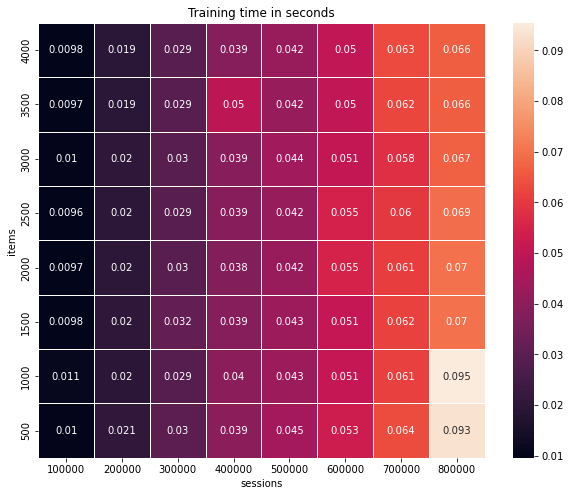

In [14]:
plt.figure(figsize=(10, 8))
sns.heatmap(transform_heatmap_data(df, col_x='sessions', col_y='items', data_col='training time [s]'), annot=True, linewidths=0.5)
plt.title('Training time in seconds')
# plt.savefig('training_time_vs_sessions_vs_items_heatmap.jpg', dpi=150)
plt.show()

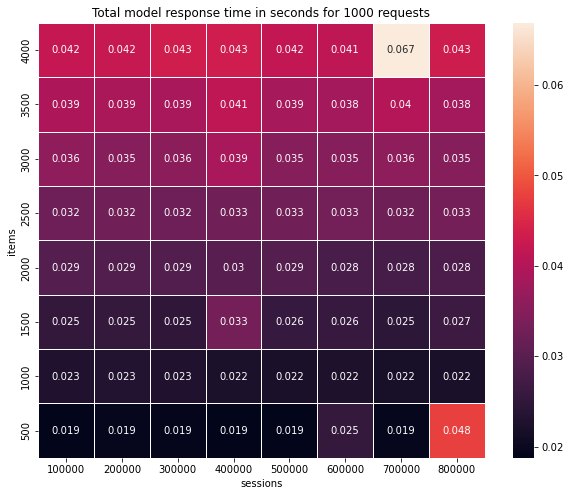

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(transform_heatmap_data(df, col_x='sessions', col_y='items', data_col='response total time x1000 [s]'), annot=True, linewidths=0.5)
plt.title('Total model response time in seconds for 1000 requests')
# plt.savefig('response_time_vs_sessions_vs_items_heatmap.jpg', dpi=150)
plt.show()

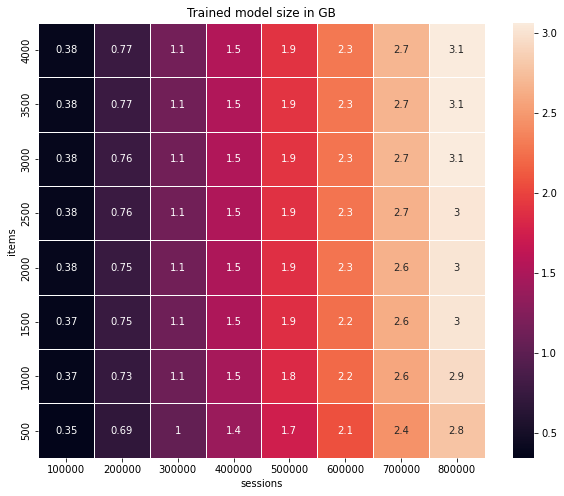

In [16]:
plt.figure(figsize=(10, 8))
sns.heatmap(0.001 * transform_heatmap_data(df, col_x='sessions', col_y='items', data_col='model size [MB]'), annot=True, linewidths=0.5)
plt.title('Trained model size in GB')
# plt.savefig('model_size_vs_sessions_vs_items_heatmap.jpg', dpi=150)
plt.show()

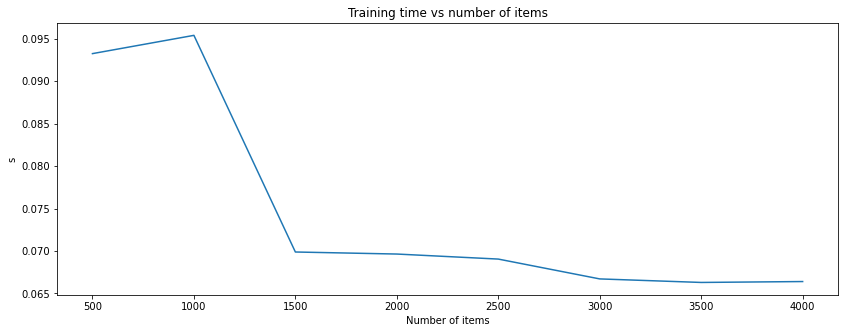

In [17]:
# Relation between number of items and training time

max_sessions_df = df[df['sessions'] == df['sessions'].max()].copy()
max_sessions_df.set_index('items', inplace=True)
max_sessions_df.sort_index(inplace=True)

plt.figure(figsize=(14, 5))
plt.plot(
    max_sessions_df['training time [s]']
)
plt.xlabel('Number of items')
plt.ylabel('s')
plt.title('Training time vs number of items')
# plt.savefig('training_time_vs_number_of_items_plot.jpg', dpi=150)
plt.show()

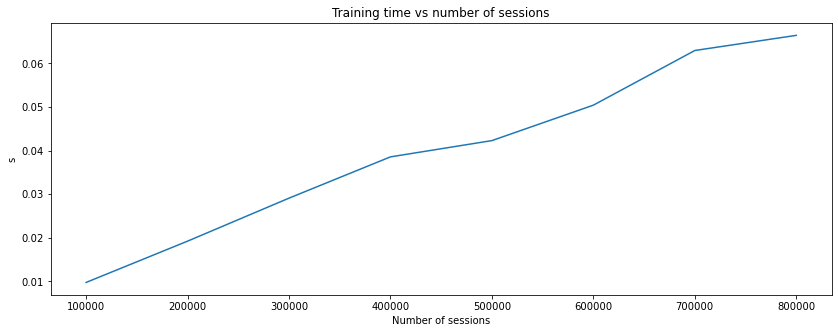

In [18]:
# Relation between number of sessions and training time

max_items_df = df[df['items'] == df['items'].max()].copy()
max_items_df.set_index('sessions', inplace=True)
max_items_df.sort_index(inplace=True)

plt.figure(figsize=(14, 5))
plt.plot(
    max_items_df['training time [s]']
)
plt.xlabel('Number of sessions')
plt.ylabel('s')
plt.title('Training time vs number of sessions')
# plt.savefig('training_time_vs_number_of_sessions_plot.jpg', dpi=150)
plt.show()

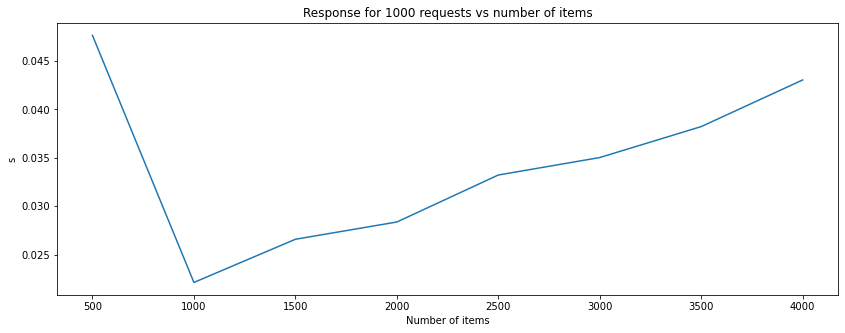

In [19]:
plt.show()
# Relation between number of items and response time

max_sessions_df = df[df['sessions'] == df['sessions'].max()].copy()
max_sessions_df.set_index('items', inplace=True)
max_sessions_df.sort_index(inplace=True)

plt.figure(figsize=(14, 5))
plt.plot(
    max_sessions_df['response total time x1000 [s]']
)
plt.xlabel('Number of items')
plt.ylabel('s')
plt.title('Response for 1000 requests vs number of items')
# plt.savefig('response_time_vs_number_of_items_plot.jpg', dpi=150)
plt.show()

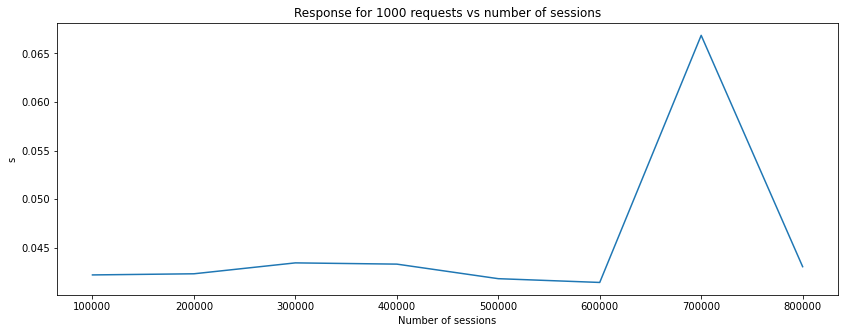

In [20]:
# Relation between number of sessions and training time

max_items_df = df[df['items'] == df['items'].max()].copy()
max_items_df.set_index('sessions', inplace=True)
max_items_df.sort_index(inplace=True)

plt.figure(figsize=(14, 5))
plt.plot(
    max_items_df['response total time x1000 [s]']
)
plt.xlabel('Number of sessions')
plt.ylabel('s')
plt.title('Response for 1000 requests vs number of sessions')
# plt.savefig('response_time_vs_number_of_sessions_plot.jpg', dpi=150)
plt.show()